In [ ]:
#import spotipy
#from spotipy.oauth2 import SpotifyOAuth
#pip install spotipy --upgrade
#spotify = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id='a6204bb2c7d44e98af9ab2c2d6518a09', client_secret='df3f58e414574e79b104f6e2ce25fd1c', redirect_uri='http://localhost/', scope = "user-read-recently-played"))

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [38]:
def get_listening_history(filename):
    """
    filename: (str) the path to the .json file containing the spotify listening history
    
    Loads in the listening history as a pandas dataframe
    Adds columns to the dataframe based on the information in the 'endTime' column of the df:
    'Date' contains the year-month-day date that the song was played
    'Time' contains the hour-minute-second time that the song finished playing
    'Month-Year' contains the year-month date that the song was played
    """
    df = pd.read_json(filename)
    df['Date'] = pd.to_datetime(df['endTime']).dt.date
    df['Time'] = pd.to_datetime(df['endTime']).dt.time
    df['Month-Year'] = pd.to_datetime(df['endTime']).dt.to_period('m')
    return df

def merge_songs(df, song_to_merge, original_song):
    """
    song_to_merge = (str) the alternate name for the song (will be replaced)
    original song = (str) the name of the song that you want to display (what to replace with)
    
    Use if the same song exists in two different versions on Spotify and is being counted separately but you want them to be counted as one
    e.g. the original version and extended version of a song
    """
    df.replace(song_to_merge,original_song,inplace=True)
    return df

def play_frequencies(df, dates, date_column_name, song_or_artist):
    """
    df = (dataframe) the name of the dataframe with the listening history
    dates = (list) the range of periods to use (days or months)
    date_column_name = (str) the name of the time period column to use ('Date' or 'Month-Year')
    
    Returns a new dataframe with the number of times each song/artist was played within the time period specified (each day or month)
    """
    play_freqs_df = pd.DataFrame()
    for date in dates:
        if song_or_artist == 'song':
            value_counts_df = df[df[date_column_name]==date][['trackName','artistName']].value_counts().to_frame().reset_index().rename(columns={0:'Number of Plays'})
        if song_or_artist == 'artist':
            value_counts_df = df[df[date_column_name]==date]['artistName'].value_counts().to_frame().reset_index().rename(columns={'index':'artistName','artistName':'Number of Plays'})
        value_counts_df[date_column_name] = date
        play_freqs_df = play_freqs_df.append(value_counts_df)
    play_freqs_df.reset_index(drop=True)
    return play_freqs_df

def print_top_per_month(df, months, song_or_artist, n=5):
    """
    df = (dataframe) the name of the dataframe with the listening history
    months = (list) the range of months-year pairs to use
    n (optional) = (int) the number of top songs/artists to display for each month. default is set to 5.
    
    Prints out the top n songs for each month with the name of the song/artist, and the number of times the song/artist was played in that month.
    """   
    for month in months:
        months_songs = df[df["Month-Year"] == month]
        if song_or_artist == 'song':
            freq = months_songs[['trackName','artistName']].value_counts()
        if song_or_artist == 'artist':
            freq = months_songs['artistName'].value_counts()
        print(month)
        print(freq.head(n))
        print()
        
def top_per_month(df, months, song_or_artist, n=1):
    """
    df = (dataframe) the name of the dataframe with the listening history
    months = (list) the range of month-year pairs to use
    n (optional) = (int) the number of top songs/artists to display for each month. default is set to 1.
    Returns a dataframe containing the top n songs/artists for each month with the name of the song/artist, number of times the song/artist was played in the month, and month.
    """
    top_df = pd.DataFrame()
    for month in months:
        months_songs = df[df["Month-Year"] == month]
        if song_or_artist == 'song':
            freq = months_songs[['trackName','artistName']].value_counts().to_frame().reset_index().rename(columns={0:'Number of Plays'})
        if song_or_artist == 'artist':
            freq = months_songs['artistName'].value_counts().to_frame().reset_index().rename(columns={'index':'artistName','artistName':'Number of Plays'})
        top_n = freq.head(n)
        top_n['Month-Year'] = month
        top_df = top_df.append(top_n)
    return top_df

def plot_top_over_time(top_df, play_freqs_df, dates, date_column_name, song_or_artist):
    """
    top_df = (df) the dataframe result of calling top_per_month()
    play_freqs_df = (df) the dataframe result of calling play_frequencies()
    dates = (list) the range of time periods to use (month-year or days)
    date_column_name = (str) the name of the time period column to use ('Date' or 'Month-Year')
    
    Returns an overlaid line plot with one line for each song/artist over the time period range that you specify
    x-axis is the time period and y-axis is number of times that song/artist was played in the time period
    """
    
    if song_or_artist == 'song':
        item_column_name = 'trackName'
    if song_or_artist == 'artist':
        item_column_name = 'artistName'
        
    top = top_df[item_column_name].unique()
    
    all_top_plays_df = pd.DataFrame()
    for item in top:
        all_plays = play_freqs_df[play_freqs_df[item_column_name]==item]
        all_top_plays_df = all_top_plays_df.append(all_plays)
    
    plt.figure(figsize=(15,10))

    for item in top:
        one_item_freqs = all_top_plays_df[all_top_plays_df[item_column_name]==item]
        freq_list = []
        for date in dates:
            if (one_item_freqs[date_column_name]==date).any():
                that_day = one_item_freqs[one_item_freqs[date_column_name]==date]
                freq_list.append(int(sum(that_day['Number of Plays'])))
            else:
                freq_list.append(0)
        dates_and_freqs_df = pd.DataFrame(data=freq_list, index=dates)
        dates_and_freqs_df.index = dates_and_freqs_df.index.to_timestamp()
        plt.plot(dates_and_freqs_df, label=item)
        plt.legend()
     
    plt.savefig(f'top_{song_or_artist}_per_month_over_time.png')
    plt.show()
    

In [3]:
df = get_listening_history('MyData/StreamingHistory0.json')
df = merge_songs(df, "MONTERO (Call Me By Your Name) - SATAN'S EXTENDED VERSION",'MONTERO (Call Me By Your Name)')

In [4]:
days = df['Date'].unique()
months = df['Month-Year'].unique()

In [5]:
top_10_songs_overall = df['trackName'].value_counts()
top_10_artists_overall = df['artistName'].value_counts()
top_10_songs_overall.head(10), top_10_artists_overall.head(10)

(MONTERO (Call Me By Your Name)    102
 good 4 u                           70
 drivers license                    67
 deja vu                            46
 SUN GOES DOWN                      45
 The Night We Met                   43
 Happier Than Ever                  43
 traitor                            42
 Angel With A Shotgun               40
 brutal                             39
 Name: trackName, dtype: int64,
 Lil Nas X              417
 Olivia Rodrigo         393
 Billie Eilish          349
 Twenty One Pilots      129
 Panic! At The Disco     95
 Fall Out Boy            77
 Maccabeats              69
 Cardi B                 65
 Lil Dicky               48
 Andrew Garfield         47
 Name: artistName, dtype: int64)

In [30]:
daily_song_freqs_df = play_frequencies(df, days, 'Date', 'song')
monthly_song_freqs_df = play_frequencies(df, months, 'Month-Year', 'song')

In [31]:
monthly_artist_freqs_df = play_frequencies(df, months, 'Month-Year', 'artist')

In [42]:
print_top_per_month(df, months, 'song')

2021-01
trackName             artistName    
The Night We Met      Lord Huron        4
Angel With A Shotgun  The Cab           4
drivers license       Olivia Rodrigo    4
WITHOUT YOU           The Kid LAROI     2
YEET                  YEET              2
dtype: int64

2021-02
trackName                                                 artistName                        
That Would Be Enough - Instrumental                       Original Broadway Cast of Hamilton    6
Prologue                                                  John Williams                         6
Total Eclipse of the Heart - Karaoke                      Best Instrumentals                    6
7 Years (Instrumental Version)                            The O'Neill Brothers Group            5
Bohemian Rhapsody (Piano Verison) [Made Famous By Queen]  Acoustic Hits                         5
dtype: int64

2021-03
trackName                                                                                                             

In [27]:
print_top_per_month(df, months, 'artist')

2021-01
Original Broadway Cast of Hamilton    13
Maccabeats                             8
ProSound Karaoke Band                  4
Olivia Rodrigo                         4
Lord Huron                             4
Name: artistName, dtype: int64

2021-02
ProSound Karaoke Band                 25
Original Broadway Cast of Hamilton    21
Panic! At The Disco                   14
Best Instrumentals                    13
John Williams                         12
Name: artistName, dtype: int64

2021-03
Panic! At The Disco    26
Fall Out Boy            7
Paul Zim                4
Jay Levy                4
Yaffa Yarkoni           4
Name: artistName, dtype: int64

2021-04
Lil Nas X         33
Cardi B           19
Lil Dicky         12
Lord Huron         9
Olivia Rodrigo     9
Name: artistName, dtype: int64

2021-05
Olivia Rodrigo         94
Lil Nas X              22
Panic! At The Disco    16
Cardi B                14
blackbear               9
Name: artistName, dtype: int64

2021-06
Olivia Rodrigo   

In [40]:
top_songs_df = top_per_month(df, months, 'song')
top_artists_df = top_per_month(df, months, 'artist')

/var/folders/yf/2mykrtbj3cxf8byxf7kttk700000gn/T/ipykernel_14986/504574072.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_n['Month-Year'] = month


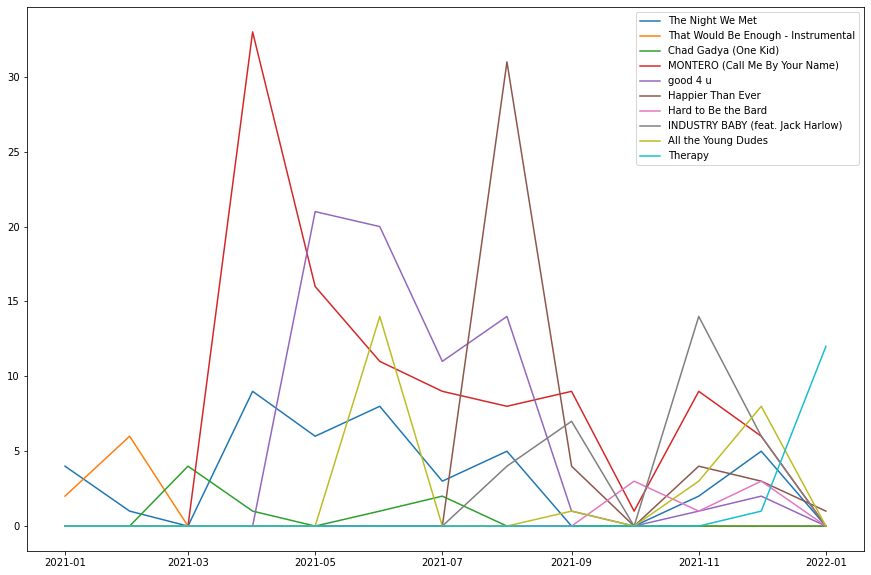

In [41]:
plot_top_over_time(top_songs_df, monthly_song_freqs_df, months, 'Month-Year', 'song')

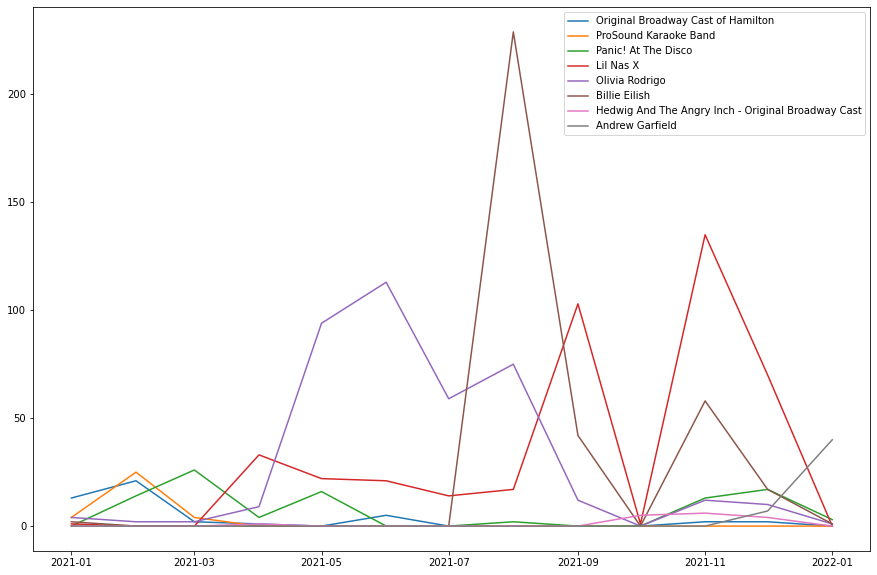

In [39]:
plot_top_over_time(top_artists_df, monthly_artist_freqs_df, months, 'Month-Year', 'artist')